In [1]:
from tensorflow import keras
import tensorflow as tf
import numpy as np
import pandas as pd
from osgeo import gdal
import matplotlib.pyplot as plt
from fire_history import get_fire_grid_bounds
import pickle
import json
from glob import glob
import os

C:\Users\mit\anaconda3\envs\dl\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\mit\anaconda3\envs\dl\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\mit\anaconda3\envs\dl\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\mit\anaconda3\envs\dl\lib\site-packages\tensorflow\python\framework\dtypes.py:5

In [4]:
dropbox_path = r"C:\Users\mit\Dropbox (MIT)\wildfire_repo"
hrrr_path = dropbox_path + '/hrrr'

with open('data/clean/bbox.json') as json_file:
    bboxes = json.load(json_file)
    
path = 'data/clean/fire_histories_revised'

In [9]:
def slope_aspect_wind_transform(slope, aspect, u_wind, v_wind, i, j):
    
    # sometimes the slope or aspect DataFrames do not read in correctly
    if np.any(aspect == -9999) or np.any(slope == -9999):
        raise ValueError('Slope or aspect not read correctly')
        
    # get the shape of the arrays, make sure they are always the same
    h, w = slope.shape
    for arr in [aspect, u_wind, v_wind]:
        if arr.shape != slope.shape:
            raise ValueError("Arrays not all of same shape")
        
    # get the distance E and N needed to travel from each pixel to (i, j) pixel 
    u_dist = np.zeros((h, w))
    v_dist = np.zeros((h, w))
    for y in range(h):
        for x in range(w):
            u_dist[y, x] = j - x
            v_dist[y, x] = y - i
            
    # get the pixel distance from each pixel to (i, j)
    dist = (v_dist ** 2 + u_dist ** 2) ** 0.5
    
    # get the U and V component of the direction of the upslope
    # (270 degrees is up E, 180 is up N)
    u_upslope = - np.sin(aspect / 180 * np.pi)
    v_upslope = - np.cos(aspect / 180 * np.pi)

    # dot product the upslope vector with the vector from pixel to (i, j)
    upslope = (u_dist * u_upslope  + v_dist * v_upslope) / dist
    
    # manually set 0/0 value at pixel (i, j) to 1
    upslope[i, j] = 1
    
    # dot product the downwind vector with the vector from pixel to (i, j)
    wind = (u_wind ** 2 + v_wind ** 2) ** 0.5
    downwind = (u_dist * u_wind + v_dist * v_wind) / (dist * wind)
    downwind[i, j] = 1
    
    # manually set 0/0 value at pixel (i, j) to 1
    return dist, upslope, downwind, wind
    

In [10]:
try:
    del static_data
except:
    pass


In [37]:
path = 'data/clean/fire_histories_revised'

In [38]:
time_fxx = [{'time' : '12z', 'fxx' : 'f00'}]


dropbox_path = r"C:\Users\mit\Dropbox (MIT)\wildfire_repo"
hrrr = dropbox_path + '/hrrr'

process_single_fire_data('data/clean/fire_histories_revised', 'data/processed', hrrr, 11917747, time_fxx)

In [35]:
def get_grid_bounds_from_geo_ds(ds):
    
    tr = ds.GetGeoTransform()
    bounds = [tr[0], tr[3] + ds.RasterYSize * tr[5], tr[0] + ds.RasterXSize * tr[1], tr[3]]
    return tr[1], -tr[5], bounds

In [36]:
def process_single_fire_data(in_dir, out_dir, hrrr_path, inc_id, time_fxx_list):
    
    # only do this if we have a fire footprint
    if not os.path.isfile(f'{in_dir}/{inc_id}/daily_fire_footprint.vrt'):
        return
    
    # make directories if needed
    if not os.path.isdir(out_dir):
        os.mkdir(out_dir)
    if not os.path.isdir(f'{out_dir}/{inc_id}'):
        os.mkdir(f'{out_dir}/{inc_id}')


    static_data = gdal.Open(f'{in_dir}/{inc_id}/static_data.vrt')
    
    # make it an array and check we read it right
    bands = [static_data.GetRasterBand(i+1) for i in range(static_data.RasterCount)]
    np_static_data = np.dstack([band.ReadAsArray() for band in bands])
    if np.any(np_static_data == -9999):
        raise ValueError('Static data read in wrong')

    # save to numpy
    np.save(f'{out_dir}/{inc_id}/static_data.npy', np_static_data)
    
    # save json with documentation of the layers
    static_data_lookup = pd.read_csv('data/input/static_data_params.csv')
    static_data_lookup = dict(zip(static_data_lookup['layer'], static_data_lookup.index))
    with open(f'{out_dir}/{inc_id}/static_data.json', 'w') as f:
        json.dump(static_data_lookup, f)

    # read geotransform info from static data, to be used to read weather data later
    lon_res, lat_res, fire_bbox = get_grid_bounds_from_geo_ds(static_data)
    
    # read fire footprint data, get number of days
    fire_footprint = gdal.Open(f'{in_dir}/{inc_id}/daily_fire_footprint.vrt')
    num_days = fire_footprint.RasterCount
    
    # for each fire day
    for fire_day in range(1, num_days+1):

        # make numbered subdirectory
        if not os.path.isdir(f'{out_dir}/{inc_id}/{fire_day}'):
            os.mkdir(f'{out_dir}/{inc_id}/{fire_day}')

        # get the raster band and the day
        fire = fire_footprint.GetRasterBand(fire_day)
        day = fire.GetDescription()
        day = day.replace('-', '')

        # for the first day only, save some global info about the fire
        if fire_day == 1:
            with open(f'{out_dir}/{inc_id}/info.json', 'w') as f:
                json.dump({'transform' : static_data.GetGeoTransform(), 
                           'shape' : np_static_data.shape[0:2],
                           'start_day' : day,
                            'num_days' : num_days}, 
                          f)

        # read the fire footprint for the day as an array, and save
        fire = fire.ReadAsArray()
        np.save(f'{out_dir}/{inc_id}/{fire_day}/fire.npy', fire)

        # for each set of time/fxx params in the list
        for d in time_fxx_list:
            
            # prepare the regex to grab corresponding GRIB file
            time = d['time']
            fxx = d['fxx']
            regex = f'{hrrr_path}/{day}/*{time}*{fxx}*grib2*'
            
            # read the grib file
            grib = glob(regex)
            grib = [i for i in grib if '.xml' not in i]
            if len(grib) != 1:
                raise ValueError("Not exactly one GRIB file found")
            grib_file = grib[0]
            ds = gdal.Open(grib_file)
            
            # slice and warp to fire bounds using info from static data
            warped = gdal.Warp('temp.vrt', ds, format='VRT', dstSRS='WGS84', xRes=lon_res, yRes=lat_res,
                      resampleAlg='bilinear', outputBounds=fire_bbox)

            # read weather data to array and save
            np_weather_data = np.dstack([warped.GetRasterBand(i+1).ReadAsArray() for i in range(warped.RasterCount)])
            np.save(f'{out_dir}/{inc_id}/{fire_day}/weather_{time}_{fxx}.npy', np_weather_data)
            
            # read and save info about the channels
            with open(f'{hrrr_path}/{day}/band_lookup_{time}.json', 'r') as f:
                band_lookup = json.load(f)
            weather_lookup = {key : band_lookup[key] - 1 for key in band_lookup}
            with open(f'{out_dir}/{inc_id}/{fire_day}/weather_{time}.json', 'w') as f:
                json.dump(weather_lookup, f)
                
    os.remove('temp.vrt')  

In [7]:
inc_id = 11917747
time = '12z'
fxx = 'f00'

bbox = bboxes[str(inc_id)]
lon_res, lat_res, fire_bbox = get_fire_grid_bounds(bbox, 0.6)

static_data = gdal.Open(f'{path}/{inc_id}/static_data.vrt')
fire_footprint = gdal.Open(f'{path}/{inc_id}/daily_fire_footprint.vrt')
fire = fire_footprint.GetRasterBand(25)
day = fire.GetDescription()
day = day.replace('-', '')

slope = static_data.GetRasterBand(2)
slope = slope.ReadAsArray()
aspect = static_data.GetRasterBand(3)
aspect = aspect.ReadAsArray()

layers = {}

regex = f'{hrrr_path}/{day}/*{time}*{fxx}*grib2*'
grib = glob(regex)
grib = [i for i in grib if '.xml' not in i]
if len(grib) != 1:
    raise ValueError("Not exactly one GRIB file found")
grib_file = grib[0]
with open(f'{hrrr_path}/{day}/band_lookup_{time}.json', 'r') as f:
    band_lookup = json.load(f)
ds = gdal.Open(grib_file)
warped = gdal.Warp('temp.vrt', ds, format='VRT', dstSRS='WGS84', xRes=lon_res, yRes=lat_res,
          resampleAlg='near', outputBounds=fire_bbox)

layers = {}
for key in band_lookup:
    band = warped.GetRasterBand(band_lookup[key])
    layers[key] = band.ReadAsArray()

u_wind = layers['UGRD:10 m']
v_wind = layers['VGRD:10 m']

In [8]:
i = 4
j = 7
dist, upslope, downwind, wind = slope_aspect_wind_transform(slope, aspect, u_wind, v_wind, i, j)

C:\Users\mit\anaconda3\envs\dl\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
C:\Users\mit\anaconda3\envs\dl\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


Text(0.5, 1.0, 'Upslope in the direction \n of the key pixel (4, 7)')

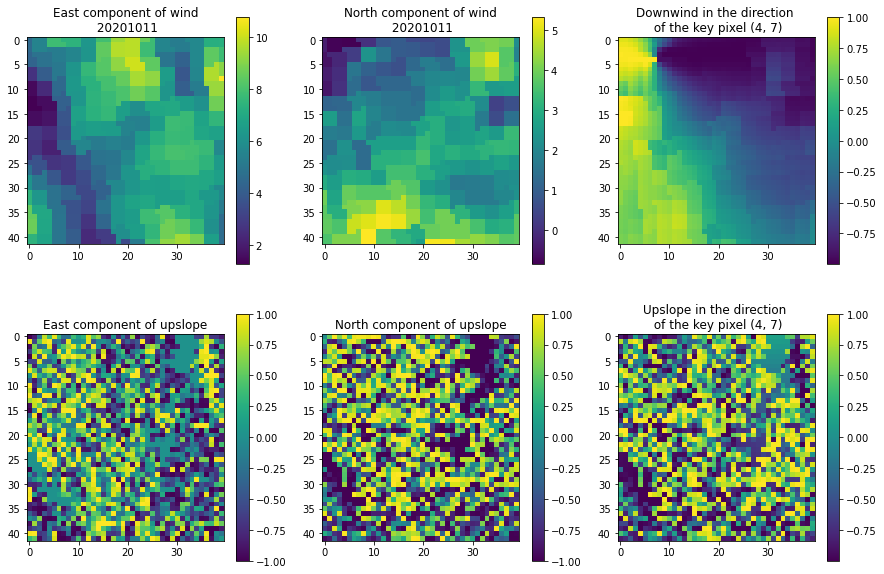

In [9]:
plt.rcParams['figure.figsize'] = (15, 10)
fig, axs = plt.subplots(2, 3)

im = axs[0,0].imshow(u_wind)
plt.colorbar(im, ax=axs[0,0])
axs[0,0].set_title(f'East component of wind\n {day}')

im = axs[0,1].imshow(v_wind)
plt.colorbar(im, ax=axs[0,1])
axs[0,1].set_title(f'North component of wind\n {day}')

im = axs[0,2].imshow(downwind)
plt.colorbar(im, ax=axs[0,2])
axs[0,2].set_title(f'Downwind in the direction \n of the key pixel ({i}, {j})')

im = axs[1,0].imshow(-np.sin(aspect / 180 * np.pi))
plt.colorbar(im, ax=axs[1,0])
axs[1,0].set_title('East component of upslope')

im = axs[1,1].imshow(-np.cos(aspect / 180 * np.pi))
plt.colorbar(im, ax=axs[1,1])
axs[1,1].set_title('North component of upslope')

im = axs[1,2].imshow(upslope)
plt.colorbar(im, ax=axs[1,2])
axs[1,2].set_title(f'Upslope in the direction \n of the key pixel ({i}, {j})')

![SegmentLocal](data/clean/fire_histories_revised/11917747/daily_fire_footprint.gif "segment")

In [10]:
def get_layers(layer_names, slope, aspect, fire_array, next_fire_array, geo_ds, band_lookup, i, j, dim,
              threshold=0.2):
    
    layers = {}
    for key in band_lookup:
        band = geo_ds.GetRasterBand(band_lookup[key])
        layers[key] = band.ReadAsArray()
    
    u_wind = layers['UGRD:10 m']
    v_wind = layers['VGRD:10 m']
    
    layers['dist'], layers['upslope'], layers['downwind'], layers['wind'] = \
        slope_aspect_wind_transform(slope, aspect, u_wind, v_wind, i, j)
    
    layers['inv_dist'] = 1/layers['dist']
    layers['inv_dist'][i, j] = layers['inv_dist'].min()
    
    layers['fire'] = fire_array
    
    if layer_names is not None:   
        to_stack = [layers[name] for name in layer_names]
    else:
        to_stack = [layers[name] for name in layers]
    stack = np.dstack(to_stack)
    stack = stack[i-dim:i+dim+1, j-dim:j+dim+1, :]
    
    output = (next_fire_array[i, j] > threshold).astype(int)
    
    return stack, output

In [16]:
inputs = []
outputs = []
layers_to_use = ['fire', 'downwind', 'wind']
dim = 10
    
for fire_day in range(1, num_days):

    
    fire = fire_footprint.GetRasterBand(fire_day)
    next_day = fire_footprint.GetRasterBand(fire_day + 1) 

    day = fire.GetDescription()
    day = day.replace('-', '')

    fire_array = fire.ReadAsArray()

    layers = {}
    regex = f'{hrrr_path}/{day}/*{time}*{fxx}*grib2*'
    grib = glob(regex)
    grib = [i for i in grib if '.xml' not in i]
    if len(grib) != 1:
        raise ValueError("Not exactly one GRIB file found")
    grib_file = grib[0]
    with open(f'{hrrr_path}/{day}/band_lookup_{time}.json', 'r') as f:
        band_lookup = json.load(f)
    ds = gdal.Open(grib_file)
    warped = gdal.Warp('temp.vrt', ds, format='VRT', dstSRS='WGS84', xRes=lon_res, yRes=lat_res,
              resampleAlg='near', outputBounds=fire_bbox)
 
    for i in range(dim, slope.shape[0] - dim):
        for j in range(dim, slope.shape[1] - dim):
            stack, output = get_layers(layers_to_use, slope, aspect, fire_array, 
                                       next_day.ReadAsArray(), warped, band_lookup, i, j, dim)
            inputs.append(stack)
            outputs.append(output)

C:\Users\mit\anaconda3\envs\dl\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
C:\Users\mit\anaconda3\envs\dl\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide
C:\Users\mit\anaconda3\envs\dl\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app


In [138]:
inputs = np.asarray(inputs)
outputs = np.asarray(outputs)

ix_to_keep = np.arange(outputs.shape[0])
np.random.seed(8)
np.random.shuffle(ix_to_keep)

inputs = inputs[ix_to_keep, :, :, :]
outputs = outputs[ix_to_keep]

In [139]:
print(inputs.shape)
print(outputs.shape)

(13200, 21, 21, 3)
(13200,)


In [140]:
1 - outputs[-2640:].mean()

0.9287878787878788

In [2]:
def slope_aspect_wind_transform(slope, aspect, u_wind, v_wind, i, j):

    # sometimes the slope or aspect DataFrames do not read in correctly
    if np.any(aspect == -9999) or np.any(slope == -9999):
        raise ValueError('Slope or aspect not read correctly')

    # get the shape of the arrays, make sure they are always the same
    h, w = slope.shape
    for arr in [aspect, u_wind, v_wind]:
        if arr.shape != slope.shape:
            raise ValueError("Arrays not all of same shape")

    # get the distance E and N needed to travel from each pixel to (i, j) pixel 
    u_dist = np.zeros((h, w))
    v_dist = np.zeros((h, w))
    for y in range(h):
        for x in range(w):
            u_dist[y, x] = j - x
            v_dist[y, x] = y - i

    # get the pixel distance from each pixel to (i, j)
    dist = (v_dist ** 2 + u_dist ** 2) ** 0.5

    # get the U and V component of the direction of the upslope
    # (270 degrees is up E, 180 is up N)
    u_upslope = - np.sin(aspect / 180 * np.pi)
    v_upslope = - np.cos(aspect / 180 * np.pi)

    # dot product the upslope vector with the vector from pixel to (i, j)
    upslope = (u_dist * u_upslope  + v_dist * v_upslope) / dist

    # manually set 0/0 value at pixel (i, j) to 1
    upslope[i, j] = 1

    # dot product the downwind vector with the vector from pixel to (i, j)
    wind = (u_wind ** 2 + v_wind ** 2) ** 0.5
    downwind = (u_dist * u_wind + v_dist * v_wind) / (dist * wind)
    downwind[i, j] = 1

    # manually set 0/0 value at pixel (i, j) to 1
    return dist, upslope, downwind, wind

In [3]:
def basic_cnn_preprocess(path, inc_id, day, i, j, dim, time, fxx, threshold, layer_names):

    with open(f'{path}/{inc_id}/static_data.json', 'r') as f:
        static_data_lookup = json.load(f)

    static_data = np.load(f'{path}/{inc_id}/static_data.npy')
    slope = static_data[:, :, static_data_lookup['slope']]
    aspect = static_data[:, :, static_data_lookup['aspect']]

    with open(f'{path}/{inc_id}/{day}/weather_{time}.json', 'r') as f:
        weather_data_lookup = json.load(f)
    weather_data = np.load(f'{path}/{inc_id}/{day}/weather_{time}_{fxx}.npy')

    layers = {}
    for key in weather_data_lookup:
        layers[key] = weather_data[:, :, weather_data_lookup[key]]

    u_wind = layers['UGRD:10 m']
    v_wind = layers['VGRD:10 m']

    layers['dist'], layers['upslope'], layers['downwind'], layers['wind'] = \
        slope_aspect_wind_transform(slope, aspect, u_wind, v_wind, i, j)

    layers['inv_dist'] = 1/layers['dist']
    layers['inv_dist'][i, j] = layers['inv_dist'].min()

    layers['fire'] = np.load(f'{path}/{inc_id}/{day}/fire.npy')

    if layer_names is not None:   
        to_stack = [layers[name] for name in layer_names]
    else:
        to_stack = [layers[name] for name in layers]
    stack = np.dstack(to_stack)
    stack = stack[i-dim:i+dim+1, j-dim:j+dim+1, :]

    next_fire_array = np.load(f'{path}/{inc_id}/{day+1}/fire.npy')
    output = (next_fire_array[i, j] > threshold).astype(int)
    
    return stack, output

In [4]:
13200 * 21 * 21 * 13 * 4 / 1000000

302.7024

In [5]:
path = 'data/processed'
dim = 10
time = '12z'
fxx = 'f00'
threshold = 0.2
layers = ['fire', 'downwind', 'wind']

all_IDs = []
inc_ids = os.listdir(path)
for inc_id in inc_ids:
    shape = np.load(f'{path}/{inc_id}/1/fire.npy').shape[0:2]
    days = sorted([int(i) for i in os.listdir(f'{path}/{inc_id}') if '.' not in i])
    days = days[:-1]
    IDs = [(inc_id, day, i, j) for day in days for i in range(dim, shape[0] - dim) \
                               for j in range(dim, shape[1] - dim)]
    all_IDs = all_IDs + IDs

inps = []
outps = []

for ID in all_IDs:
    inc_id, day, i, j = ID
    inp, outp = basic_cnn_preprocess(path, inc_id, day, i, j, dim, time, fxx, threshold, layers)
    inps.append(inp)
    outps.append(outp)

C:\Users\mit\anaconda3\envs\dl\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
C:\Users\mit\anaconda3\envs\dl\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide
C:\Users\mit\anaconda3\envs\dl\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in true_divide


In [6]:
np.mean(outps)

0.06856060606060606

In [7]:
inputs = np.asarray(inps)
outputs = np.asarray(outps)

ix_to_keep = np.arange(outputs.shape[0])
np.random.seed(8)
np.random.shuffle(ix_to_keep)

inputs = inputs[ix_to_keep, :, :, :]
outputs = outputs[ix_to_keep]

In [11]:
if not os.path.isdir('data/cnn_input'):
    os.mkdir('data/cnn_input')
    
for i, output in enumerate(outputs):
    np.save(f'data/cnn_input/{i}.npy', inputs[i, :, :, :])


In [8]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, labels, batch_size=32, dim=(21, 21), n_channels=3, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            X[i,] = np.load('data/cnn_input/' + str(ID) + '.npy')

            # Store class
            y[i] = self.labels[ID]

        return X, y

In [9]:
# Generators
training_generator = DataGenerator(range(10560), outputs)
validation_generator = DataGenerator(range(10560, 13200), outputs)

In [10]:
1 - outputs[-2640:].mean()

0.9287878787878788

In [25]:
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout

model = keras.Sequential(
    [
        keras.Input(shape=inputs.shape[1:]),
        Conv2D(5, kernel_size=(2, 2), activation="relu", name="Conv_1"),
        MaxPool2D(),
        Flatten(),
        Dense(256, activation="relu"),   
        Dropout(0.2), 
        Dense(2, activation="softmax", name="Output")
    ]

)

In [26]:
display(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv_1 (Conv2D)              (None, 20, 20, 5)         65        
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 10, 10, 5)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 500)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               128256    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
Output (Dense)               (None, 2)                 514       
Total params: 128,835
Trainable params: 128,835
Non-trainable params: 0
________________________________________________

None

In [27]:
model.compile(loss='sparse_categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

In [28]:
callbacks = [keras.callbacks.ModelCheckpoint(
    filepath='cnn_from_scratch.keras',
    save_best_only=True,
    monitor='val_acc')]

In [29]:
callbacks = [keras.callbacks.ModelCheckpoint(
    filepath='cnn_from_scratch.keras',
    save_best_only=True,
    monitor='val_acc')]

# This callback will tell the trainer that we must store the weights that give the best accuracy in validation

model.fit(inputs,
         outputs,
         batch_size=32,
         epochs=15,
         validation_split=0.2,
         callbacks=callbacks)

Train on 10560 samples, validate on 2640 samples
Epoch 1/15
10560/10560 [==============================] - 5s 445us/sample - loss: 0.3151 - acc: 0.9282 - val_loss: 0.2068 - val_acc: 0.9299
Epoch 2/15
10560/10560 [==============================] - 2s 144us/sample - loss: 0.1987 - acc: 0.9343 - val_loss: 0.1802 - val_acc: 0.9337
Epoch 3/15
10560/10560 [==============================] - 1s 141us/sample - loss: 0.1719 - acc: 0.9381 - val_loss: 0.1864 - val_acc: 0.9356
Epoch 4/15
10560/10560 [==============================] - 1s 141us/sample - loss: 0.1586 - acc: 0.9421 - val_loss: 0.1575 - val_acc: 0.9409
Epoch 5/15
10560/10560 [==============================] - 2s 152us/sample - loss: 0.1418 - acc: 0.9451 - val_loss: 0.1455 - val_acc: 0.9413
Epoch 6/15
10560/10560 [==============================] - 1s 139us/sample - loss: 0.1333 - acc: 0.9485 - val_loss: 0.1382 - val_acc: 0.9455
Epoch 7/15
10560/10560 [==============================] - 1s 138us/sample - loss: 0.1192 - acc: 0.9535 - val_lo

In [31]:
sorted_IDs = [all_IDs[i] for i in ix_to_keep]

In [263]:
inc_ids = set([i[0] for i in sorted_IDs])
path = 'data/processed'

fires = {}
for inc_id in inc_ids:
    with open(f'{path}/{inc_id}/info.json', 'r') as f:
        info = json.load(f)
    shape = info['shape']
    days = info['num_days']
    arr_shape = tuple(shape) + (days,)
    fires[inc_id] = np.full(arr_shape, 'No prediction', dtype='object')

In [264]:
y_pred = np.argmax(model.predict(inputs), axis=1)

In [265]:
for i, ID in enumerate(sorted_IDs):
    
    pred = y_pred[i]
    actual = outputs[i]
    train = i < 10560

    val = 'Error'
    if pred == 0 and actual == 0:
        val = 'True Negative'
    if pred == 1 and actual == 1:
        val = 'True Positive'
    if pred == 1 and actual == 0:
        val = 'False Positive'
    if pred == 0 and actual == 1:
        val = 'False Negative'
        
    # haha a little bit on the nose
    if val == 'Error':
        raise ValueError() 
        
    if train:
        val = 'Train ' + val
    else:
        val = 'Validation ' + val
        
    inc, day, i, j = ID
    
    # note that 1-indexing and next day cancel each other out, not day+1
    fires[inc_id][i, j, day] = val
        

In [304]:
path = f'data/processed/{inc_id}'
day = 10

In [328]:
def f(s, green=[], red=[]):

    if s in green:
        return 1
    if s in red:
        return -1
    return 0

func = np.vectorize(f, excluded=['green', 'red'])

Text(0.5, 1.0, 'Validation True Negative/Validation False Positive')

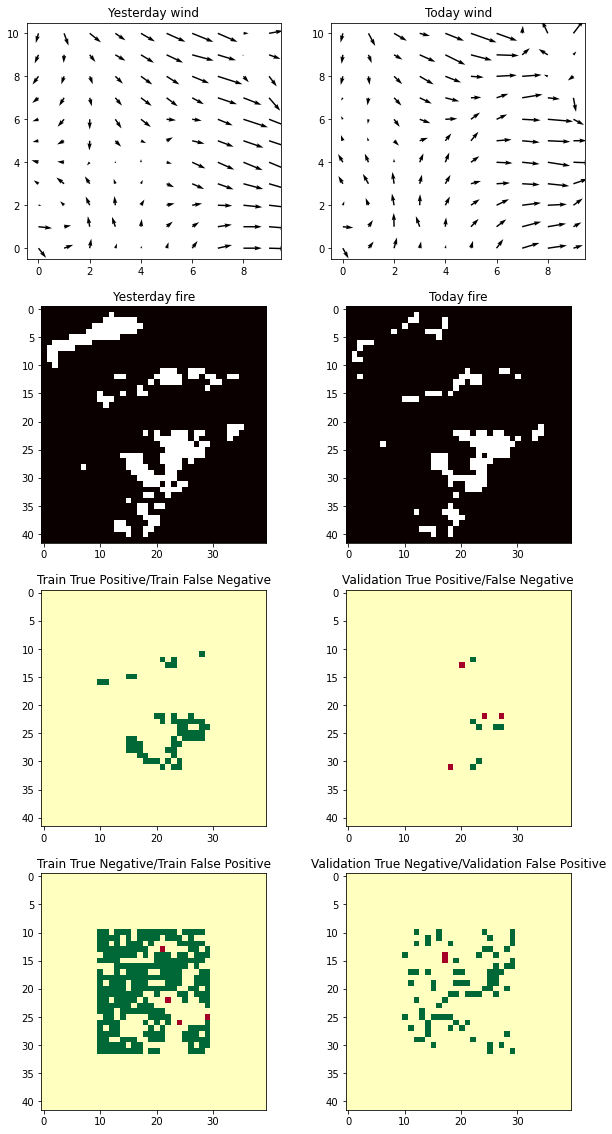

In [331]:
path = f'data/processed/{inc_id}'
day = 20

plt.rcParams['figure.figsize'] = (10, 20)
fig, axs = plt.subplots(4, 2)

weather = np.load(f'{path}/{day-1}/weather_12z_f00.npy')
with open(f'{path}/{day-1}/weather_12z.json', 'r') as f:
    bands = json.load(f)
u_wind = weather[:, :, bands['UGRD:10 m']]
v_wind = weather[:, :, bands['VGRD:10 m']]
axs[0, 0].quiver(np.flip(u_wind, axis=0)[::4, ::4], np.flip(v_wind, axis=0)[::4, ::4], scale=100)
axs[0, 0].set_title('Yesterday wind')

weather = np.load(f'{path}/{day}/weather_12z_f00.npy')
with open(f'{path}/{day}/weather_12z.json', 'r') as f:
    bands = json.load(f)
u_wind = weather[:, :, bands['UGRD:10 m']]
v_wind = weather[:, :, bands['VGRD:10 m']]
axs[0, 1].quiver(np.flip(u_wind, axis=0)[::4, ::4], np.flip(v_wind, axis=0)[::4, ::4], scale=100)
axs[0, 1].set_title('Today wind')

fire = np.load(f'{path}/{day-1}/fire.npy')
fire = fire > 0.2
axs[1, 0].imshow(fire, cmap='hot')
axs[1,0].set_title('Yesterday fire')

fire = np.load(f'{path}/{day}/fire.npy')
fire = fire > 0.2
axs[1, 1].imshow(fire, cmap='hot')
axs[1,1].set_title('Today fire')


day_fire = fires[inc_id][:, :, day-1]
d = {'green' : ['Train True Positive'], 'red' : ['Train True Positive']}
axs[2, 0].imshow(func(day_fire, **d), cmap = plt.cm.get_cmap('RdYlGn', 3), vmin=-1, vmax=1)
axs[2,0].set_title('Train True Positive/Train False Negative')

d = {'green' : ['Validation True Positive'], 'red' : ['Validation False Negative']}
axs[2, 1].imshow(func(day_fire, **d), cmap = plt.cm.get_cmap('RdYlGn', 3), vmin=-1, vmax=1)
axs[2,1].set_title('Validation True Positive/False Negative')

d = {'green' : ['Train True Negative'], 'red' : ['Train False Positive']}
axs[3, 0].imshow(func(day_fire, **d), cmap = plt.cm.get_cmap('RdYlGn', 3), vmin=-1, vmax=1)
axs[3,0].set_title('Train True Negative/Train False Positive')

d = {'green' : ['Validation True Negative'], 'red' : ['Validation False Positive']}
axs[3, 1].imshow(func(day_fire, **d), cmap = plt.cm.get_cmap('RdYlGn', 3), vmin=-1, vmax=1)
axs[3,1].set_title('Validation True Negative/Validation False Positive')





In [18]:
model.fit_generator(generator=training_generator,
                    validation_data=validation_generator,
                    use_multiprocessing=False,
                    epochs=15,
                    workers=2)

Epoch 1/15
330/330 [==============================] - 7s 22ms/step - loss: 0.0122 - acc: 0.9953 - val_loss: 0.2449 - val_acc: 0.9569
Epoch 2/15
330/330 [==============================] - 5s 16ms/step - loss: 0.0120 - acc: 0.9956 - val_loss: 0.2619 - val_acc: 0.9539
Epoch 3/15
110/330 [=========>....................] - ETA: 2s - loss: 0.0141 - acc: 0.9952

KeyboardInterrupt: 

In [147]:
input_val = inputs[-2640:]
output_val = outputs[-2640:]

y_pred = np.argmax(model.predict(inputs[-2640:]), axis=1)

In [151]:
np.sum((y_pred == 1) & (output_val == 1)),\
np.sum((y_pred == 1) & (output_val == 0)),\
np.sum((y_pred == 0) & (output_val == 1)),\
np.sum((y_pred == 0) & (output_val == 0))


(109, 35, 79, 2417)

In [152]:
109/(109+35)

0.7569444444444444

In [153]:
109/(109+79)

0.5797872340425532

In [154]:
2417/(2417+35)

0.9857259380097879

In [145]:
y_hat = np.argmax(model.predict(inputs), axis=1)

In [146]:
np.unique(y_hat, return_counts=True)

(array([0, 1], dtype=int64), array([12437,   763], dtype=int64))

In [ ]:
output

In [17]:
path = 'data/processed'

13200

In [ ]:
ID = (path, inc_id, day, i, j)

In [ ]:
time = '12z'
fxx = 'f00'
path = 'data/processed'
inc_id = 11917747
dim = 10
i = 14
j = 17
day = 1
layer_names = None
threshold = 0.2

In [14]:
a, b = basic_cnn_preprocess('data/processed', 11917747, 5, 14, 17, 10, '12z', 'f00', 0.2, ['fire', 'downwind', 'wind'])

C:\Users\mit\anaconda3\envs\dl\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
C:\Users\mit\anaconda3\envs\dl\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide
C:\Users\mit\anaconda3\envs\dl\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in true_divide


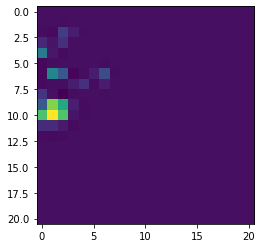

In [15]:
plt.imshow(a[:,:,0])